## Gradabillity model: Res-net 50

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [23]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image

from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import CrossEntropyFlat
import torch.nn as nn
from torch import tensor

from glaucoma.helpers.glaucoma_helpers import *

In [3]:
import warnings

warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')


In [5]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR / 'training'
GRADE_DIR = DATA_DIR / "gradable"

In [6]:
meta_df = pickle.load(open(DATA_DIR / "meta_df_v5.pkl",'rb'))

In [9]:
# as we can see some images here are different size

In [10]:
unzipped_files = parse_files(str(DATA_DIR / "unzipped"))

In [11]:
# split up unzipped files
unzipped_head, unzipped_tail = split_unzipped(unzipped_files)

## Making dataset

## Modelling:

In [12]:
path_img = GRADE_DIR


In [187]:
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_rotate= 10,flip_vert =True, max_lighting = 0.1) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [14]:
#using smaller image size
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_folder()
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(400,520) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data.show_batch(3, figsize=(10,10), hide_axis=False)

In [15]:
# Running a basic image net
learn = cnn_learner(data,models.resnet34, pretrained = True)

In [16]:
learn.data.batch_size = 64

In [17]:
learn.metrics =[accuracy]

In [ ]:
# change weighting as required
learn.loss_func = CrossEntropyFlat(weight = tensor([0.5,1]))

In [18]:
#learn.unfreeze()

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


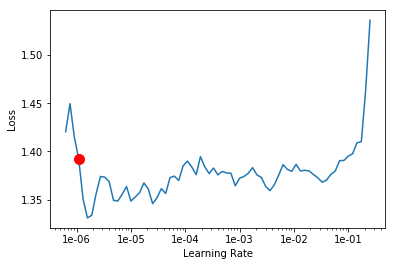

In [128]:
learn.recorder.plot(suggestion = True,)

## Training

In [20]:
min_grad_lr = 1.10E-06

In [ ]:
learn.fit_one_cycle(3,min_grad_lr,callbacks=[SaveModelCallback(learn,name = "gradable_res34_clean_best_heat_1")])

In [ ]:
learn.save("gradable_resnet_34_stage_1_e3")

In [ ]:
learn.show_results()

## Testing

In [132]:
preds = learn.get_preds()

In [133]:
root_mean_squared_error(preds[0],preds[1])

tensor(1.1617)

In [134]:
mean_absolute_error(*preds)

tensor(0.8620)

In [135]:
exp_rmspe(*preds)

tensor(9.1563)

In [136]:
mean_squared_error(preds[0],preds[1])

tensor(1.3496)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [137]:
r2_score(*preds)

tensor(0.6089)

## memory management

In [29]:
torch.cuda.empty_cache()